## Particles tracking within Ereefs (delayed start)

The [OceanParcels](http://oceanparcels.org) project develops `Parcels` (*Probably A Really Computationally Efficient Lagrangian Simulator*), a set of Python classes and methods to create customisable particle tracking simulations using output from Ocean Circulation models. 

:::{note}
Parcels can be used to track passive and active particulates such as: 
+ water, 
+ plankton, 
+ [plastic](http://topios.org) and 
+ fish.
:::

In this notebook, I will first cover how to run a set of *particles* from exported regridded [eReefs data](http://thredds.ereefs.aims.gov.au/thredds/catalog.html). Then I will use particles to sample a field such as *temperature* and write a kernel that tracks the *distance travelled by the particles*.

:::{seealso}
The [OceanParcels](http://oceanparcels.org) team has designed a series of Jupyter notebooks to help people to get started with `Parcels`. You can find the tutorials on this [link](http://oceanparcels.org/#tutorials)!
:::

## Load the required Python libraries

First of all, load the necessary libraries:

In [1]:
import os
import numpy as np
import xarray as xr

import cmocean

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
cartopy.config['data_dir'] = os.getenv('CARTOPY_DIR', cartopy.config.get('data_dir'))

from parcels import FieldSet, Field, ParticleSet, Variable, JITParticle
from parcels import AdvectionRK4, plotTrajectoriesFile, ErrorCode

import math
from datetime import timedelta
from operator import attrgetter


from matplotlib import pyplot as plt
#%config InlineBackend.figure_format = 'retina'
plt.ion()  # To trigger the interactive inline mode

#plotting shapefiles
import shapefile as shp  # Requires the pyshp package
import matplotlib.pyplot as plt

#The required SWOT Track
sf = shp.Reader("swot_calval_hr_Dec2022-v07_swath.shp")

## Build multi-file dataset

We will use the `open_mfdataset` function from `xArray` to open multiple netCDF files into a single xarray Dataset. 

We will query load the GBR4km dataset from the [AIMS server](http://thredds.ereefs.aims.gov.au/thredds/catalog.html), so let's first define the base URL:

In [2]:
# For the hydro dataset
base_url = "http://thredds.ereefs.aims.gov.au/thredds/dodsC/s3://aims-ereefs-public-prod/derived/ncaggregate/ereefs/gbr4_v2/daily-monthly/EREEFS_AIMS-CSIRO_gbr4_v2_hydro_daily-monthly-"

In [3]:
month_st = 5   # Starting month 
month_ed = 5   # Ending month 
year = 2022   # Year

# Based on the server the file naming convention 
hydrofiles = [f"{base_url}{year}-{month:02}.nc" for month in range(month_st, month_ed+1)]

### Loading dataset into xArray

Using `xArray`, we open these files into a `Dataset`:

In [4]:
ds_hydro = xr.open_mfdataset(hydrofiles)
ds_hydro

<xarray.Dataset>
Dimensions:      (time: 31, k: 17, latitude: 723, longitude: 491)
Coordinates:
    zc           (k) float64 dask.array<chunksize=(17,), meta=np.ndarray>
  * time         (time) datetime64[ns] 2022-04-30T14:00:00 ... 2022-05-30T14:...
  * latitude     (latitude) float64 -28.7 -28.67 -28.64 ... -7.096 -7.066 -7.036
  * longitude    (longitude) float64 142.2 142.2 142.2 ... 156.8 156.8 156.9
Dimensions without coordinates: k
Data variables:
    mean_cur     (time, k, latitude, longitude) float32 dask.array<chunksize=(31, 17, 723, 491), meta=np.ndarray>
    salt         (time, k, latitude, longitude) float32 dask.array<chunksize=(31, 17, 723, 491), meta=np.ndarray>
    temp         (time, k, latitude, longitude) float32 dask.array<chunksize=(31, 17, 723, 491), meta=np.ndarray>
    u            (time, k, latitude, longitude) float32 dask.array<chunksize=(31, 17, 723, 491), meta=np.ndarray>
    v            (time, k, latitude, longitude) float32 dask.array<chunksize=(31, 17, 723, 491), meta=np.ndarray>
    mean_wspeed  (time, latitude, longitude) float32 dask.array<chunksize=(31, 723, 491), meta=np.ndarray>
    eta          (time, latitude, longitude) float32 dask.array<chunksize=(31, 723, 491), meta=np.ndarray>
    wspeed_u     (time, latitude, longitude) float32 dask.array<chunksize=(31, 723, 491), meta=np.ndarray>
    wspeed_v     (time, latitude, longitude) float32 dask.array<chunksize=(31, 723, 491), meta=np.ndarray>
Attributes: (12/24)
    Conventions:                     CF-1.0
    Parameter_File_Revision:         $Revision: 1753 $
    Run_ID:                          2.1
    Run_code:                        GBR4 Hydro|G0.00|H2.10|S0.00|B0.00
    _CoordSysBuilder:                ucar.nc2.dataset.conv.CF1Convention
    aims_ncaggregate_buildDate:      2023-01-25T03:50:21+10:00
    ...                              ...
    prefix_list_puv__:               https://w3id.org/env/puv#
    prefix_list_qudt__:              http://qudt.org/vocab/unit/
    technical_guide_link:            https://eatlas.org.au/pydio/public/aims-...
    technical_guide_publish_date:    2020-08-18
    title:                           eReefs AIMS-CSIRO GBR4 Hydrodynamic v2 d...
    DODS_EXTRA.Unlimited_Dimension:  time

### Clip the Dataset

To reduce the `Dataset` size we will clip the spatial extent based on longitudinal and latitudinal values. 

This is easely done using the `sel` function with the `slice` method.

In clipping the dataset, it is important to ensure that the correct depth (k) is selected.

In [5]:
min_lon = 146     # lower left longitude
min_lat = -21     # lower left latitude
max_lon = 149     # upper right longitude
max_lat = -18     # upper right latitude
#min_depth = 16
#max_depth = 17

# Defining the boundaries
lon_bnds = [min_lon, max_lon]
lat_bnds = [min_lat, max_lat]
#depth_bnds = [min_depth, max_depth]

# Performing the reduction and only taking the surface dataset (k=-1)
#ds_hydro_clip = ds_hydro.sel(latitude=slice(*lat_bnds), longitude=slice(*lon_bnds), k=slice(*depth_bnds))
ds_hydro_clip = ds_hydro.sel(latitude=slice(*lat_bnds), longitude=slice(*lon_bnds), k=16)

#k=16 or k=-1 ensures the surface field is selected.
#for Parcels to work, a single level is required for k. Selecting the depth is importantly
ds_hydro_clip

<xarray.Dataset>
Dimensions:      (time: 31, latitude: 100, longitude: 100)
Coordinates:
    zc           float64 dask.array<chunksize=(), meta=np.ndarray>
  * time         (time) datetime64[ns] 2022-04-30T14:00:00 ... 2022-05-30T14:...
  * latitude     (latitude) float64 -20.99 -20.96 -20.93 ... -18.05 -18.02
  * longitude    (longitude) float64 146.0 146.0 146.1 ... 148.9 148.9 149.0
Data variables:
    mean_cur     (time, latitude, longitude) float32 dask.array<chunksize=(31, 100, 100), meta=np.ndarray>
    salt         (time, latitude, longitude) float32 dask.array<chunksize=(31, 100, 100), meta=np.ndarray>
    temp         (time, latitude, longitude) float32 dask.array<chunksize=(31, 100, 100), meta=np.ndarray>
    u            (time, latitude, longitude) float32 dask.array<chunksize=(31, 100, 100), meta=np.ndarray>
    v            (time, latitude, longitude) float32 dask.array<chunksize=(31, 100, 100), meta=np.ndarray>
    mean_wspeed  (time, latitude, longitude) float32 dask.array<chunksize=(31, 100, 100), meta=np.ndarray>
    eta          (time, latitude, longitude) float32 dask.array<chunksize=(31, 100, 100), meta=np.ndarray>
    wspeed_u     (time, latitude, longitude) float32 dask.array<chunksize=(31, 100, 100), meta=np.ndarray>
    wspeed_v     (time, latitude, longitude) float32 dask.array<chunksize=(31, 100, 100), meta=np.ndarray>
Attributes: (12/24)
    Conventions:                     CF-1.0
    Parameter_File_Revision:         $Revision: 1753 $
    Run_ID:                          2.1
    Run_code:                        GBR4 Hydro|G0.00|H2.10|S0.00|B0.00
    _CoordSysBuilder:                ucar.nc2.dataset.conv.CF1Convention
    aims_ncaggregate_buildDate:      2023-01-25T03:50:21+10:00
    ...                              ...
    prefix_list_puv__:               https://w3id.org/env/puv#
    prefix_list_qudt__:              http://qudt.org/vocab/unit/
    technical_guide_link:            https://eatlas.org.au/pydio/public/aims-...
    technical_guide_publish_date:    2020-08-18
    title:                           eReefs AIMS-CSIRO GBR4 Hydrodynamic v2 d...
    DODS_EXTRA.Unlimited_Dimension:  time

We will now drop all unnecessary variables. 

Basically we will only need the current velocities (`u` and `v`) and the variable we want to track with the parcels (here `temp`):

In [6]:
surf_data = ds_hydro_clip.drop(['zc','mean_wspeed','salt','eta','wspeed_u','wspeed_v', 'mean_cur'])
#surf_data

[OceanParcels](http://oceanparcels.org) will need to read the file locally and we save it using the `Xarray` funciton `to_netcdf`. Otherwise you could use the `from_xarray_dataset` function to directly read the dataset in `Parcels`.

:::{note}
Here the cell has been commented to make the notebook run faster, but you will need to uncomment it for running your how experiment...
:::

In [7]:
data_name ='ereefdata_May22_v1.1.nc'
try:
     os.remove(data_name)
except OSError:
     pass

surf_data.to_netcdf(path=data_name)

## Reading velocities into Parcels

As we used the `NetCDF` format, it is fairly easy to load the velocity fields into the `FieldSet.from_netcdf()` function available in `Parcels`:

In [8]:
filenames = {'U': data_name,
             'V': data_name}

Then, define a dictionary of the variables (`U` and `V`) and dimensions (`lon`, `lat` and `time`; note that in this case there is no depth because we only took the surface variables from the `eReefs` datastet:

In [9]:
variables = {'U': 'u',
             'V': 'v'}

dimensions = {'lat': 'latitude',
              'lon': 'longitude',
              'time': 'time'}

the eReefs data that we loaded in is only for a limited, regional domain and particles might be able to leave this domain. 

We therefore need to tell `Parcels` that particles that leave the domain need to be deleted. We do that using a `Recovery Kernel`, which will be invoked when a particle encounters an `ErrorOutOfBounds error`:

In [10]:
def DeleteParticle(particle, fieldset, time):
    particle.delete()

Finally, we read in the fieldset using the `FieldSet.from_netcdf` function with the above-defined `filenames`, `variables` and `dimensions`

In [11]:
fieldset = FieldSet.from_netcdf(filenames, variables, dimensions)

The part delays the release of the particles. For L = 5, minutes=13.5, L = 10 minutes=27, L=15 minutes=40

L = the distance between the triange particles

In [12]:
npart = 10  # number of particles to be released
time = np.arange(0,npart)*timedelta(minutes=40).total_seconds()  # release every particle in a delayed mode

Now define a `ParticleSet`, in this case using the `ParticleSet.from_line` constructor method:

In [13]:
#Line Plotting

#pset = ParticleSet.from_line(fieldset=fieldset, 
                             #pclass=JITParticle,
                             #size=npart,             # releasing X particles
                             #start=(147.5, -19.5),   # releasing on a line: the start longitude and latitude
                             #finish=(148.0, -19.0),
                             #time=time)  # release every particle one hour

In [14]:
#Box south of Mooring

#pset = ParticleSet.from_line(fieldset=fieldset, 
                             #pclass=JITParticle,
                             #size=npart,             # releasing X particles
                             #start=(147.6, -19.6),   # releasing on a line: the start longitude and latitude
                             #finish=(147.8, -19.4),
                             #time=time)  # release every particle one hour

In [15]:
#Box North of Mooring

pset = ParticleSet.from_line(fieldset=fieldset, 
                             pclass=JITParticle,
                             size=npart,             # releasing X particles
                             start=(147.6, -19.2),   # releasing on a line: the start longitude and latitude
                             finish=(147.8, -19.0),
                             time=time)  # release every particle one hour

## Plotting the start for the particle run 


P[0](lon=147.600006, lat=-19.200001, depth=0.000000, time=0.000000)
P[1](lon=147.622223, lat=-19.177778, depth=0.000000, time=2400.000000)
P[2](lon=147.644440, lat=-19.155556, depth=0.000000, time=4800.000000)
P[3](lon=147.666672, lat=-19.133333, depth=0.000000, time=7200.000000)
P[4](lon=147.688889, lat=-19.111111, depth=0.000000, time=9600.000000)
P[5](lon=147.711105, lat=-19.088888, depth=0.000000, time=12000.000000)
P[6](lon=147.733337, lat=-19.066668, depth=0.000000, time=14400.000000)
P[7](lon=147.755554, lat=-19.044445, depth=0.000000, time=16800.000000)
P[8](lon=147.777771, lat=-19.022223, depth=0.000000, time=19200.000000)
P[9](lon=147.800003, lat=-19.000000, depth=0.000000, time=21600.000000)


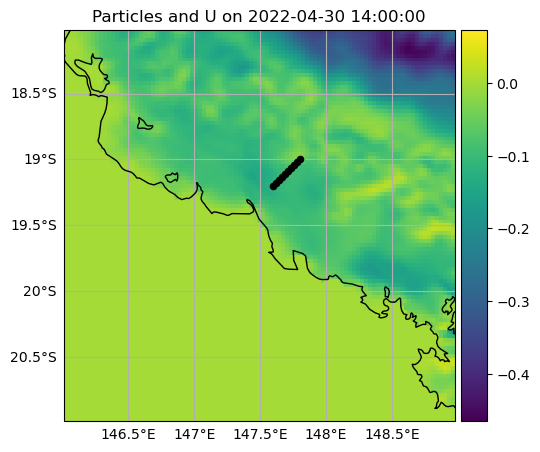

In [16]:
print(pset)
pset.show(field=fieldset.U)

In [17]:
output_file = pset.ParticleFile(name="CurrentParticles.zarr", outputdt=timedelta(hours=1))  # the file name and the time step of the outputs

pset.execute(AdvectionRK4,  # the kernel (which defines how particles move)
             runtime=timedelta(days=10), # the total length of the run
             dt=timedelta(minutes=5), # the timestep of the kernel
             output_file=output_file,
             recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle})

output_zarr = 'CurrentParticles.zarr'
try:
    os.remove(output_zarr)
except OSError:
    pass

INFO: Compiled ArrayJITParticleAdvectionRK4 ==> C:\Users\Matthew\AppData\Local\Temp\parcels-tmp\lib20793c581202783af0a68e8862f5080f_0.dll
INFO: Output files are stored in CurrentParticles.zarr.
100%|██████████| 864000.0/864000.0 [00:36<00:00, 23628.41it/s]  


:::{note}
Another approach if you want to list a series of initial positions consists in using the `from_list` [function](https://oceanparcels.org/gh-pages/html/#module-parcels.particlesets.particlesetsoa) which takes:
+ lon – List of initial longitude values for particles
+ lat – List of initial latitude values for particles
:::

Now we want to advect the particles. However, the eReefs data that we loaded in is only for a limited, regional domain and particles might be able to leave this domain. 

We therefore need to tell `Parcels` that particles that leave the domain need to be deleted. We do that using a `Recovery Kernel`, which will be invoked when a particle encounters an `ErrorOutOfBounds error`:

## Plotting outputs

We open the particles file with `Xarray`:

In [18]:
parcels = xr.open_dataset(output_zarr)
#parcels

C:\Users\Matthew\anaconda3\lib\site-packages\xarray\backends\plugins.py:139: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
C:\Users\Matthew\anaconda3\lib\site-packages\xarray\backends\plugins.py:139: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


## Plotting the end for the particle run 


P[0](lon=146.646332, lat=-18.934019, depth=0.000000, time=864000.000000)
P[1](lon=146.656448, lat=-18.916151, depth=0.000000, time=864000.000000)
P[2](lon=146.670944, lat=-18.888922, depth=0.000000, time=864000.000000)
P[3](lon=146.701324, lat=-18.855053, depth=0.000000, time=864000.000000)
P[4](lon=146.748230, lat=-18.866369, depth=0.000000, time=864000.000000)
P[5](lon=146.871643, lat=-18.999531, depth=0.000000, time=864000.000000)
P[6](lon=146.939331, lat=-19.036722, depth=0.000000, time=864000.000000)
P[7](lon=146.990692, lat=-19.057396, depth=0.000000, time=864000.000000)
P[8](lon=147.036423, lat=-19.053423, depth=0.000000, time=864000.000000)
P[9](lon=147.080368, lat=-19.048208, depth=0.000000, time=864000.000000)


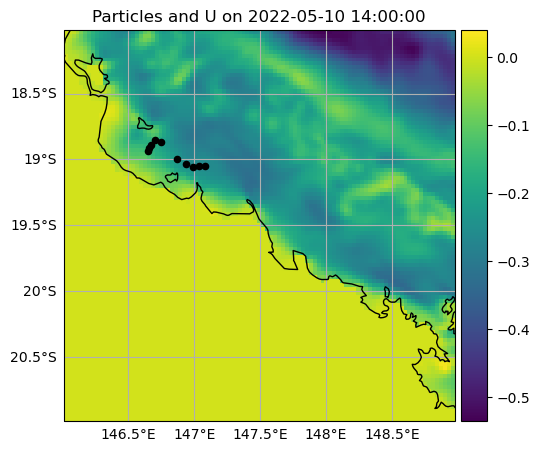

In [19]:
print(pset)
pset.show(field=fieldset.U)

## Plotting Temp outputs

We open the particles file with `Xarray`:

In [20]:
min_lon_drifter = 147
max_lon_drifter = 148.5
min_lat_drifter = -20
max_lat_drifter = -18.7

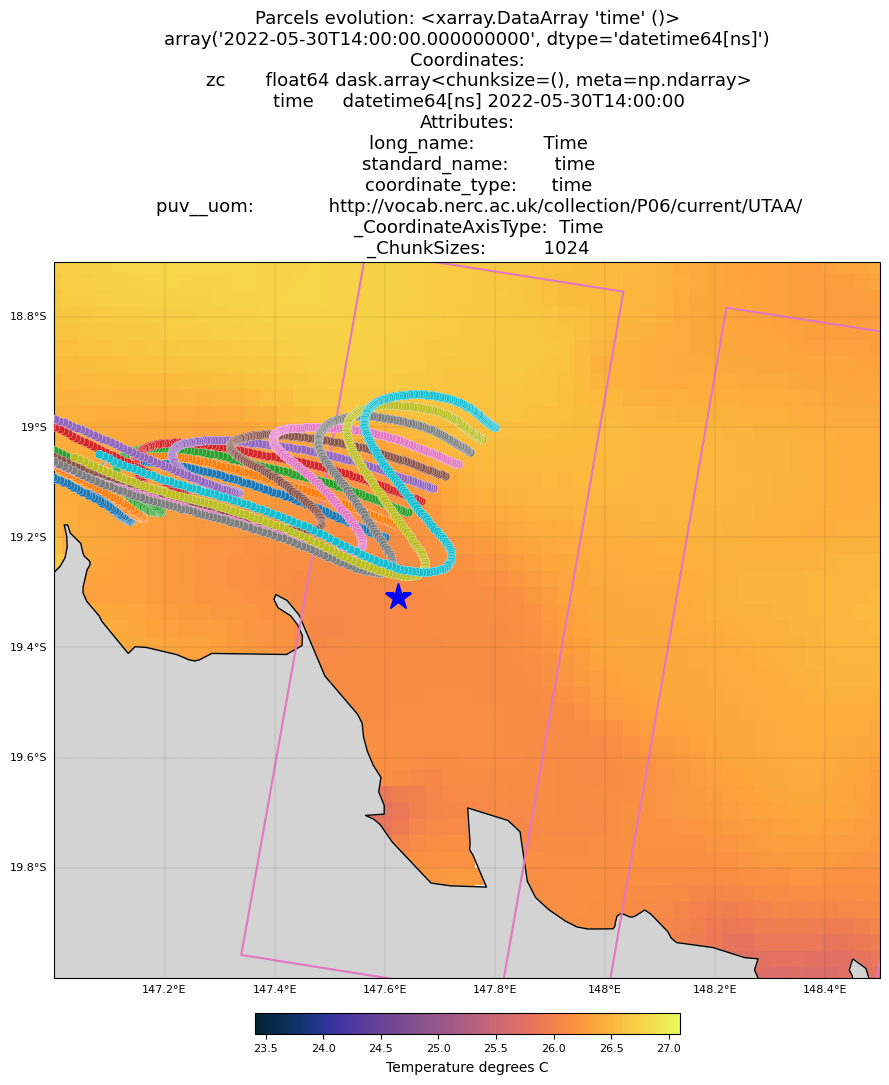

<Figure size 640x480 with 0 Axes>

In [21]:
i=30
imagetitle = 'temp_may_2022_day_30.png'
min_lon_drifter

# Figure size
size = (9, 10)

# Color from cmocean
color = cmocean.cm.thermal

# Defining the figure
fig = plt.figure(figsize=size, facecolor='w', edgecolor='k')

# Axes with Cartopy projection
ax = plt.axes(projection=ccrs.PlateCarree())
# and extent
#ax.set_extent([min_lon, max_lon, min_lat, max_lat], ccrs.PlateCarree())
ax.set_extent([min_lon_drifter, max_lon_drifter, min_lat_drifter, max_lat_drifter], ccrs.PlateCarree())

# Plotting using Matplotlib 
# We plot the PH at the surface at the final recorded time interval
#cf = ds_hydro_clip.temp.isel(time=i).plot(transform=ccrs.PlateCarree(), cmap=color,vmin=25, vmax = 28, alpha=1,
#                                              add_colorbar=False)
cf = ds_hydro_clip.temp.isel(time=i).plot(transform=ccrs.PlateCarree(), cmap=color, alpha=1,
                                              add_colorbar=False)
#Plotting the SWOT Tracks
for shape in sf.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x,y)
    
# Color bar
cbar = fig.colorbar(cf, ax=ax, fraction=0.027, pad=0.045, orientation="horizontal")
cbar.set_label(ds_hydro_clip.temp.long_name+' '+ds_hydro_clip.temp.units, rotation=0, labelpad=5, fontsize=10)
cbar.ax.tick_params(labelsize=8)

# Title
plt.title('Parcels evolution: '+ str(ds_hydro_clip.time.isel(time=i)), fontsize=13)

# Plot lat/lon grid 
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.1, color='k', alpha=1, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 8}
gl.ylabel_style = {'size': 8} 

# Add map features with Cartopy 
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face', facecolor='lightgray'))
ax.coastlines(linewidth=1)

for k in range(parcels.lon.shape[0]):
    ax.scatter(parcels.lon.isel(trajectory=k), parcels.lat.isel(trajectory=k), s=40, edgecolors='w', 
               linewidth=0.2, transform=ccrs.PlateCarree()).set_zorder(11)

Yongala_LONLAT = [147.625,-19.308333];
plt.plot(Yongala_LONLAT[0],Yongala_LONLAT[1],'b*', markersize=20)
        
plt.tight_layout()
#plt.savefig(imagetitle)
plt.show()
fig.clear()
plt.close(fig)
plt.clf()

In [22]:
plotTrajectoriesFile(output_zarr, mode='movie2d_notebook')

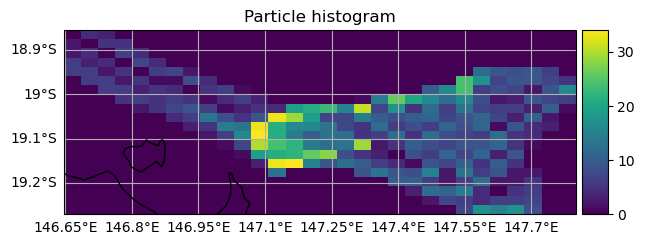

In [23]:
plotTrajectoriesFile(output_zarr, mode='hist2d', bins=[30, 20]);

## Plotting Mean WSpeed outputs

We open the particles file with `Xarray`:

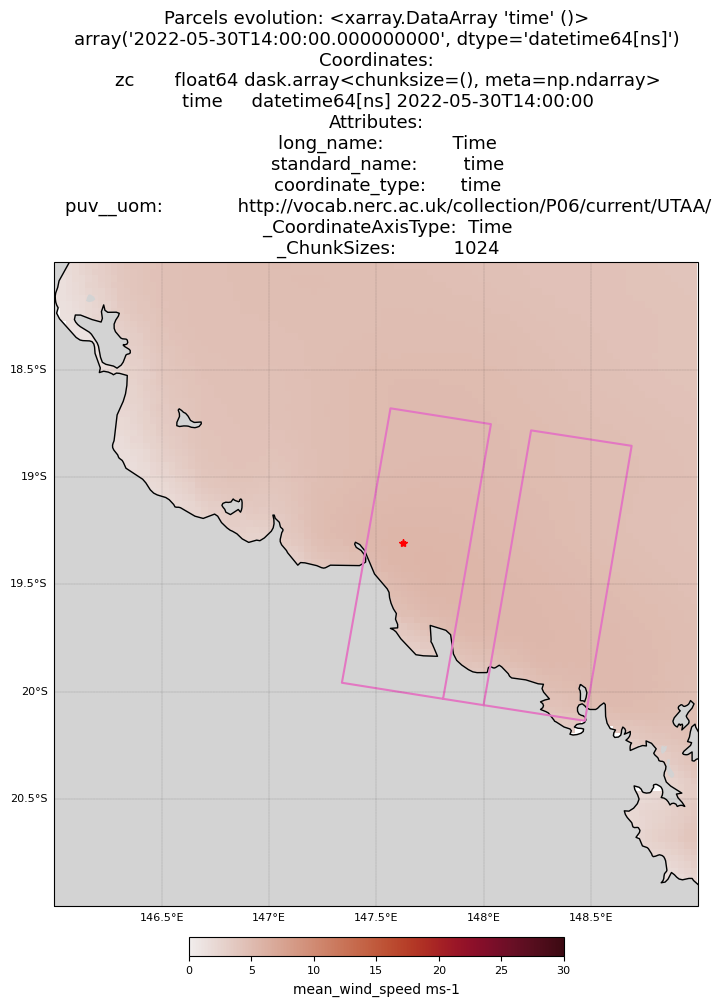

<Figure size 640x480 with 0 Axes>

In [24]:
i=30
imagetitle = 'mean_wspeed_may_2022_day_30.png'

# Figure size
size = (9, 10)

# Color from cmocean
color = cmocean.cm.amp

# Defining the figure
fig = plt.figure(figsize=size, facecolor='w', edgecolor='k')

# Axes with Cartopy projection
ax = plt.axes(projection=ccrs.PlateCarree())
# and extent
ax.set_extent([min_lon, max_lon, min_lat, max_lat], ccrs.PlateCarree())

# Plotting using Matplotlib 
# We plot the PH at the surface at the final recorded time interval
cf = ds_hydro_clip.mean_wspeed.isel(time=i).plot(transform=ccrs.PlateCarree(), cmap=color, vmin = 0, vmax = 30, alpha=1,
                                              add_colorbar=False)
#Plotting the SWOT Tracks
for shape in sf.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x,y)
    
# Color bar
cbar = fig.colorbar(cf, ax=ax, fraction=0.027, pad=0.045, orientation="horizontal")
cbar.set_label(ds_hydro_clip.mean_wspeed.long_name+' '+ds_hydro_clip.mean_wspeed.units, rotation=0, labelpad=5, fontsize=10)
cbar.ax.tick_params(labelsize=8)

# Title
plt.title('Parcels evolution: '+ str(ds_hydro_clip.time.isel(time=i)), fontsize=13)

# Plot lat/lon grid 
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.1, color='k', alpha=1, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 8}
gl.ylabel_style = {'size': 8} 

# Add map features with Cartopy 
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face', facecolor='lightgray'))
ax.coastlines(linewidth=1)

#for k in range(parcels.lon.shape[0]):
    #ax.scatter(parcels.lon.isel(traj=k), parcels.lat.isel(traj=k), s=40, edgecolors='w', 
               #linewidth=0.2, transform=ccrs.PlateCarree()).set_zorder(11)

Yongala_LONLAT = [147.625,-19.308333];
plt.plot(Yongala_LONLAT[0],Yongala_LONLAT[1],'r*')
        
plt.tight_layout()
#plt.savefig(imagetitle)
plt.show()
fig.clear()
plt.close(fig)
plt.clf()

## Sampling a Field with Particles

One typical use case of particle simulations is to sample a Field (such as temperature, salinity, surface hight) along a particle trajectory. In `Parcels`, this is very easy to do, with a `custom Kernel`.


Let's define the `FieldSet` as above:

In [25]:
filenames = {'U': data_name,
             'V': data_name,
            }

In [26]:
variables = {'U': 'u',
             'V': 'v',
            }

dimensions = {'lat': 'latitude',
              'lon': 'longitude',
              'time': 'time'}

Finally, we read in the fieldset using the `FieldSet.from_netcdf` function with the above-defined `filenames`, `variables` and `dimensions`

In [27]:
fieldset = FieldSet.from_netcdf(filenames, variables, dimensions)

We now add the field `temperature` to the `FieldSet`

In [28]:
filenames = {'lat': data_name,
             'lon': data_name,
             'data': data_name}

variable = ('T', 'temp')

dimensions = {'lat': 'latitude',
              'lon': 'longitude',
              'time': 'time'}

field = Field.from_netcdf(filenames, variable, dimensions)
fieldset.add_field(field)

Now define a new `Particle class` that has an extra Variable: the **temperature**. We initialise this by sampling the `fieldset2.T` field.

In [29]:
class SampleParticle(JITParticle):          # Define a new particle class
    t = Variable('t', initial=fieldset.T)  # Variable 't' initialised by sampling the temperature

Now define a `ParticleSet` using the `from_line` method also used above. Plot the `pset` and print their temperature values `t`:

In [30]:
pset = ParticleSet.from_line(fieldset=fieldset, pclass=SampleParticle, 
                             size=5,               # releasing 5 particles
                             start=(147, -18.5),   # releasing on a line: the start longitude and latitude
                             finish=(148, -17.5),  # releasing on a line: the end longitude and latitude
                             time=0)
print('t values before execution:', [p.t for p in pset])

FieldOutOfBoundError: T sampled out-of-bound, at (147.500000, -18.000000, 0.000000)

Now create a custom function that samples the `fieldset.T` field at the particle location. Cast this function to a Kernel.

In [ ]:
def SampleT(particle, fieldset, time):  # Custom function that samples fieldset2.T at particle location
    particle.t = fieldset.T[time, particle.depth, particle.lat, particle.lon]

k_sample = pset.Kernel(SampleT)    # Casting the SampleT function to a kernel.

Finally, execute the pset with a combination of the `AdvectionRK4` and `SampleT` kernels, plot the pset and print their new temperature values `t`:

In [ ]:
output_nc_temp = 'CurrentParticlesTemp.nc'
try:
    os.remove(output_nc_temp)
except OSError:
    pass

In [ ]:
output_file_temp = pset.ParticleFile(name=output_nc_temp, 
                                outputdt=timedelta(hours=6))

pset.execute(AdvectionRK4 + k_sample,    # Add kernels using the + operator.
             runtime=timedelta(days=30),
             dt=timedelta(minutes=5),
             output_file=output_file_temp,
             recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle})

output_file_temp.export()

### Plotting the result

We can extract the netcdf file values...

In [ ]:
parcels_temp = xr.open_dataset(output_nc_temp)
parcels_temp

And plot the resulting parcels output on a map:

In [ ]:
# Figure size
size = (9, 10)

# Color from cmocean
color = cmocean.cm.speed

# Defining the figure
fig = plt.figure(figsize=size, facecolor='w', edgecolor='k')

# Axes with Cartopy projection
ax = plt.axes(projection=ccrs.PlateCarree())
# and extent
ax.set_extent([min_lon, max_lon, min_lat, max_lat], ccrs.PlateCarree())

# Plotting using Matplotlib 
# We plot the PH at the surface at the final recorded time interval
cf = ds_hydro_clip.mean_cur.isel(time=10).plot( 
    transform=ccrs.PlateCarree(), cmap=color,
    vmin = 0.1, vmax = 1.0, alpha=0.2, 
    add_colorbar=False
)

# Color bar
cbar = fig.colorbar(cf, ax=ax, fraction=0.027, pad=0.045, 
                    orientation="horizontal")
cbar.set_label(ds_hydro_clip.mean_cur.long_name+' '+ds_hydro_clip.mean_cur.units, rotation=0, 
               labelpad=5, fontsize=10)
cbar.ax.tick_params(labelsize=8)

# Title
plt.title('Parcels evolution coloured by surface temperature',
          fontsize=13
         )

# Plot lat/lon grid 
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.1, color='k', alpha=1, 
                  linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 8}
gl.ylabel_style = {'size': 8} 

# Add map features with Cartopy 
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', 
                                            edgecolor='face', 
                                            facecolor='lightgray'))
ax.coastlines(linewidth=1)

distmin = parcels_temp.t.min().item()
distmax = parcels_temp.t.max().item()

for k in range(parcels_temp.lon.shape[0]):
    sc = plt.scatter(parcels_temp.lon.isel(traj=k), parcels_temp.lat.isel(traj=k), s=40, 
               c=parcels_temp.t.isel(traj=k), edgecolors='k', 
               cmap=cmocean.cm.balance, vmin=distmin, vmax=distmax, 
               linewidth=0.2, transform=ccrs.PlateCarree()).set_zorder(11)

# Color bar
cbar2 = plt.colorbar(sc, ax=ax, fraction=0.027, pad=0.045)
cbar2.set_label('Surface temperature in degree C', rotation=90, 
               labelpad=5, fontsize=10)
cbar2.ax.tick_params(labelsize=8)

plt.tight_layout()
plt.show()
fig.clear()
plt.close(fig)
plt.clf()

## Calculating distance travelled

As a second example of what custom kernels can do, we will now show how to create a kernel that logs the total distance that particles have travelled.

First, we need to create a new `Particle class` that includes three extra variables. The distance variable will be written to output, but the auxiliary variables `prev_lon` and `prev_lat` won't be written to output (can be controlled using the `to_write` keyword)

In [ ]:
class DistParticle(JITParticle):  # Define a new particle class that contains three extra variables
    
    distance = Variable('distance', initial=0., dtype=np.float32)  # the distance travelled
    prev_lon = Variable('prev_lon', dtype=np.float32, to_write=False,
                        initial=attrgetter('lon'))  # the previous longitude
    prev_lat = Variable('prev_lat', dtype=np.float32, to_write=False,
                        initial=attrgetter('lat'))  # the previous latitude.


Now define a new function `TotalDistance` that calculates the sum of Euclidean distances between the old and new locations in each `RK4` step:

In [ ]:
def TotalDistance(particle, fieldset, time):
    
    # Calculate the distance in latitudinal direction (using 1.11e2 kilometer per degree latitude)
    lat_dist = (particle.lat - particle.prev_lat) * 1.11e2
    # Calculate the distance in longitudinal direction, using cosine(latitude) - spherical earth
    lon_dist = (particle.lon - particle.prev_lon) * 1.11e2 * math.cos(particle.lat * math.pi / 180)
    # Calculate the total Euclidean distance travelled by the particle
    particle.distance += math.sqrt(math.pow(lon_dist, 2) + math.pow(lat_dist, 2))

    particle.prev_lon = particle.lon  # Set the stored values for next iteration.
    particle.prev_lat = particle.lat

:::{Note} 
Here it is assumed that the latitude and longitude are measured in degrees North and East, respectively. However, some datasets give them measured in (kilo)meters, in which case we must not include the factor 1.11e2.
:::

We will run the `TotalDistance` function on a `ParticleSet` containing the five particles within the eReefs fieldset similar to the one we did above. 

Note that `pclass=DistParticle` in this case.

In [ ]:
filenames = {'U': data_name,
             'V': data_name,
            }

variables = {'U': 'u',
             'V': 'v'}

dimensions = {'lat': 'latitude',
              'lon': 'longitude',
              'time': 'time'}

fieldset = FieldSet.from_netcdf(filenames, variables, dimensions)

pset = ParticleSet.from_line(fieldset=fieldset, 
                             pclass=DistParticle,
                             size=5,               # releasing 5 particles
                             start=(147, -18.5),   # releasing on a line: the start longitude and latitude
                             finish=(148, -17.5),  # releasing on a line: the end longitude and latitude
                             )

Again we define a new kernel to include the function written above and execute the `ParticleSet`.

In [ ]:
output_nc_dist = 'CurrentParticlesDist.nc'
try:
    os.remove(output_nc_dist)
except OSError:
    pass

file_dist = pset.ParticleFile(name=output_nc_dist, 
                                outputdt=timedelta(hours=1))

k_dist = pset.Kernel(TotalDistance)  # Casting the TotalDistance function to a kernel.

pset.execute(AdvectionRK4 + k_dist,  # Add kernels using the + operator.
             runtime=timedelta(days=30),
             dt=timedelta(minutes=5),
             output_file=file_dist,
             recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle})

file_dist.export()

We can now print the distance in km that each particle has travelled:

In [ ]:
print([p.distance for p in pset]) # the distances in km travelled by the particles

### Plotting the result

We can extract the netcdf file values...

In [ ]:
parcels_dist = xr.open_dataset(output_nc_dist)
parcels_dist

And plot the resulting parcels output on a map:

In [ ]:
# Figure size
size = (9, 10)

# Color from cmocean
color = cmocean.cm.speed

# Defining the figure
fig = plt.figure(figsize=size, facecolor='w', edgecolor='k')

# Axes with Cartopy projection
ax = plt.axes(projection=ccrs.PlateCarree())
# and extent
ax.set_extent([min_lon, max_lon, min_lat, max_lat], ccrs.PlateCarree())

# Plotting using Matplotlib 
# We plot the PH at the surface at the final recorded time interval
cf = ds_hydro_clip.mean_cur.isel(time=10).plot( 
    transform=ccrs.PlateCarree(), cmap=color,
    vmin = 0.1, vmax = 1.0, alpha=0.2, 
    add_colorbar=False
)

# Color bar
cbar = fig.colorbar(cf, ax=ax, fraction=0.027, pad=0.045, 
                    orientation="horizontal")
cbar.set_label(ds_hydro_clip.mean_cur.long_name+' '+ds_hydro_clip.mean_cur.units, rotation=0, 
               labelpad=5, fontsize=10)
cbar.ax.tick_params(labelsize=8)

# Title
plt.title('Parcels evolution coloured by travelled distance',
          fontsize=13
         )

# Plot lat/lon grid 
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.1, color='k', alpha=1, 
                  linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 8}
gl.ylabel_style = {'size': 8} 

# Add map features with Cartopy 
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', 
                                            edgecolor='face', 
                                            facecolor='lightgray'))
ax.coastlines(linewidth=1)

distmin = parcels_dist.distance.min().item()
distmax = parcels_dist.distance.max().item()

for k in range(parcels_dist.lon.shape[0]):
    sc = plt.scatter(parcels_dist.lon.isel(traj=k), parcels_dist.lat.isel(traj=k), s=40, 
               c=parcels_dist.distance.isel(traj=k), edgecolors='w', 
               cmap='jet', vmin=distmin, vmax=distmax, 
               linewidth=0.2, transform=ccrs.PlateCarree()).set_zorder(11)

# Color bar
cbar2 = plt.colorbar(sc, ax=ax, fraction=0.027, pad=0.045)
cbar2.set_label('Travelled distance in km', rotation=90, 
               labelpad=5, fontsize=10)
cbar2.ax.tick_params(labelsize=8)

plt.tight_layout()
plt.show()
fig.clear()
plt.close(fig)
plt.clf()

:::{seealso}
[Tutorial](https://nbviewer.jupyter.org/github/OceanParcels/parcels/blob/master/parcels/examples/tutorial_output.ipynb) on how to analyse Parcels output         
:::